# In-depth Analysis of the Blood Donation Dataset
### Joseph Petersen - Springboard Capstone 1

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.calibration import CalibratedClassifierCV

plt.style.use('ggplot')

In [2]:
# Read in the csv file
df = pd.read_csv('data/transfusion.csv')
# Rename the columns for clarity
df.columns = ['months_since_last', 'total_times_donated', 'total_cc_blood_donated', 'months_since_first', 
              'donated_march_2007']
# Calculate the frequency column
df['frequency'] = df.months_since_first / df.total_times_donated
# Reindex into a more logical structure
df = df.reindex(columns=['months_since_first', 'months_since_last', 'total_times_donated', 'total_cc_blood_donated', 
                         'frequency', 'donated_march_2007'])

df_wb = df.copy() # Dataframe with total blood intact
df = df.drop('total_cc_blood_donated', axis=1) # Dataframe without total blood
df_nf = df.drop('frequency', axis=1) # Dataframe without frequency
df_min = df.drop(['months_since_first', 'total_times_donated'], axis=1) # Dataframe just frequency and recency

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
months_since_first     748 non-null int64
months_since_last      748 non-null int64
total_times_donated    748 non-null int64
frequency              748 non-null float64
donated_march_2007     748 non-null int64
dtypes: float64(1), int64(4)
memory usage: 29.3 KB


In [4]:
def adjusted_threshold(y_scores, t):

    # This function adjusts predictions or a probability array based on the threshold 't' value
    # It looks at the probability of the '1' in a binary response variable
    
    return [1 if y[1] >= t else 0 for y in y_scores]

def con_mat(model, X_train, X_test, y_train, y_test, y_pred):

    # This function takes  train/test and prediction data to produce a
    # graphed confusion matrix and classification report
    
    cm = confusion_matrix(y_test, y_pred)
    labels=['Non-Returners', 'Returners']
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of donated_march_2007')
    ttl = ax.title
    ttl.set_position([.5, 1.1])
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w", fontsize=24)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print(classification_report(y_test, y_pred))
    

## Logistic Regression Model

In [169]:
print("Distribution of response variable (full dataset):")
print(df.donated_march_2007.value_counts())
print("Mean:", df.donated_march_2007.mean())

Distribution of response variable (full dataset):
0    570
1    178
Name: donated_march_2007, dtype: int64
Mean: 0.23796791443850268


The response variable is unbalanced. Only about 24% of the response column is a returner (1) with the rest being non-returners (0). We're going to balance it by upscaling using SMOTE, but first we need to split the data into training/testing sets.

In [170]:
# Split the data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('donated_march_2007', axis=1).values, 
                                             df.donated_march_2007.values, random_state=23, test_size=0.2)

print("Distribution of response variable (training set):")
print(pd.Series(y_train).value_counts())
print("Mean:", y_train.mean())

Distribution of response variable (training set):
0    458
1    140
dtype: int64
Mean: 0.23411371237458195


### Unbalanced Logistic Regression

Before we upscale, let's take a look at what a logistic regression model can do with the data as is.

In [171]:
# Tuning the parameters
Cs = np.logspace(0, 4, 10)
penalty=['l1', 'l2']
param_grid = {'C':Cs, 
              'penalty':penalty}
logreg = LogisticRegression(solver='liblinear')
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)
logreg_cv.fit(X_train, y_train)

print("Tuned LR Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score: {}".format(logreg_cv.best_score_))

Tuned LR Parameters: {'C': 2.7825594022071245, 'penalty': 'l2'}
Best score: 0.7842809364548495


In [172]:
best_c = logreg_cv.best_params_['C']
best_p = logreg_cv.best_params_['penalty']

In [173]:
logreg = LogisticRegression(C=best_c, penalty=best_p, solver='liblinear')
logreg.fit(X_train, y_train)
print("Model Accuracy:", accuracy_score(logreg.predict(X_test), y_test))

Model Accuracy: 0.72


[[107   5]
 [ 37   1]]


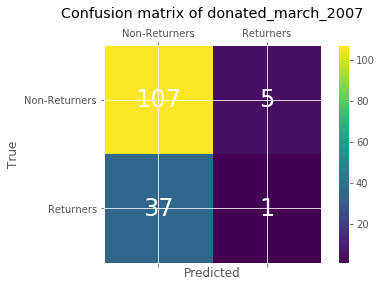

              precision    recall  f1-score   support

           0       0.74      0.96      0.84       112
           1       0.17      0.03      0.05        38

   micro avg       0.72      0.72      0.72       150
   macro avg       0.45      0.49      0.44       150
weighted avg       0.60      0.72      0.64       150



In [174]:
y_pred = logreg.predict(X_test)
con_mat(logreg, X_train, X_test, y_train, y_test, y_pred)

As the above confusion matrix shows, an out-of-the-box logistic regression model can get a relatively high accuracy. However, it misclassifies the vast majority of the 1's. The accuracy remains high due to the imbalanced response variable despite precision and recall of the response variable being very low.

The logistic regression classifier has a parameter 'class_weight' which deals with unbalanced data. For other models, the training set will need to be upsampled.

In [175]:
logreg = LogisticRegression(C=best_c, penalty=best_p, solver='liblinear', class_weight='balanced')
logreg.fit(X_train, y_train)
print("Model Accuracy:", accuracy_score(logreg.predict(X_test), y_test))

Model Accuracy: 0.6466666666666666


[[68 44]
 [ 9 29]]


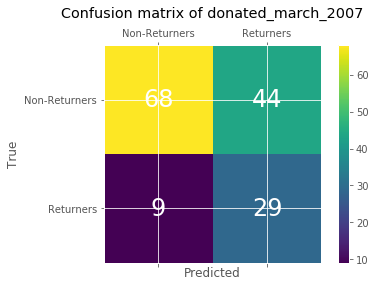

              precision    recall  f1-score   support

           0       0.88      0.61      0.72       112
           1       0.40      0.76      0.52        38

   micro avg       0.65      0.65      0.65       150
   macro avg       0.64      0.69      0.62       150
weighted avg       0.76      0.65      0.67       150



In [176]:
y_pred = logreg.predict(X_test)
con_mat(logreg, X_train, X_test, y_train, y_test, y_pred)

The linear SVM model also has a class weight parameter. Let's try that before upsampling.

In [177]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.fit_transform(X_test)

C_range = np.logspace(-2, 10, 13)
param_grid = {'C':C_range}

linsvm = LinearSVC(dual=False, class_weight='balanced')
linsvm_cv = GridSearchCV(linsvm, param_grid, cv=5, scoring='recall')
linsvm_cv.fit(X_train_s, y_train)

print("Tuned SVM Parameters: {}".format(linsvm_cv.best_params_)) 
print("Best score: {}".format(linsvm_cv.best_score_))

Tuned SVM Parameters: {'C': 0.01}
Best score: 0.7927018633540373


In [178]:
best_c = linsvm_cv.best_params_['C']

In [179]:
linsvm = LinearSVC(C=best_c, dual=False, class_weight='balanced')
linsvm.fit(X_train_s, y_train)

print("Model accuracy:", accuracy_score(linsvm.predict(X_test_s), y_test))

Model accuracy: 0.62


[[64 48]
 [ 9 29]]


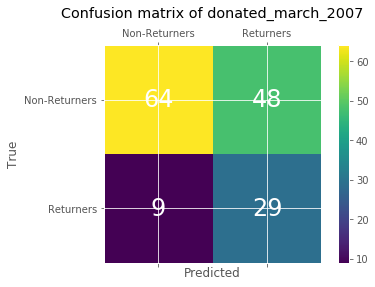

              precision    recall  f1-score   support

           0       0.88      0.57      0.69       112
           1       0.38      0.76      0.50        38

   micro avg       0.62      0.62      0.62       150
   macro avg       0.63      0.67      0.60       150
weighted avg       0.75      0.62      0.64       150



In [180]:
y_pred = linsvm.predict(X_test_s)
con_mat(linsvm, X_train_s, X_test_s, y_train, y_test, y_pred)

### Upsampling the data

SMOTE upsamples the response variable to match the independent variables. This is done over the training set.

In [181]:
# Upsampling the training set
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

print("Distribution of response variable (upscaled training set):")
print(pd.Series(y_train).value_counts())
print("Mean:", y_train.mean())

Distribution of response variable (upscaled training set):
1    458
0    458
dtype: int64
Mean: 0.5


### Balanced Logistic Regression

Now let's try the logistic regression again with the upsampled data.

In [182]:
# Parameter tuning the upsampled data on a logistic regression model
penalty = ['l1', 'l2']
Cs = np.logspace(0, 4, 10)
param_grid = {'penalty':penalty,
              'C':Cs}

logreg = LogisticRegression(solver='liblinear')
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, scoring='recall')
logreg_cv.fit(X_train, y_train)

print("Tuned LR Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score: {}".format(logreg_cv.best_score_))

Tuned LR Parameters: {'C': 2.7825594022071245, 'penalty': 'l1'}
Best score: 0.8100436681222707


In [183]:
best_c = logreg_cv.best_params_['C']
best_pen = logreg_cv.best_params_['penalty']

In [184]:
logreg = LogisticRegression(penalty=best_pen, C=best_c, solver='liblinear')
logreg.fit(X_train, y_train)

print("Model accuracy:", accuracy_score(logreg.predict(X_test), y_test))

Model accuracy: 0.6333333333333333


The accuracy decreased, but let's check the confusion matrix to see the full effects.

[[67 45]
 [10 28]]


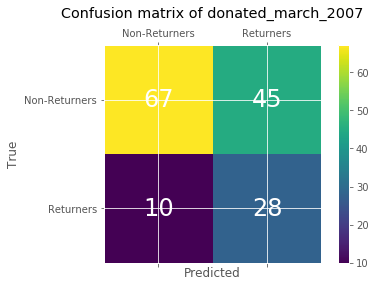

              precision    recall  f1-score   support

           0       0.87      0.60      0.71       112
           1       0.38      0.74      0.50        38

   micro avg       0.63      0.63      0.63       150
   macro avg       0.63      0.67      0.61       150
weighted avg       0.75      0.63      0.66       150



In [185]:
y_pred = logreg.predict(X_test)
con_mat(logreg, X_train, X_test, y_train, y_test, y_pred)

The model has substantially improved. It did about as well as the logistic regression with balanced class weight. Precision increased in both the positive and negative, and recall increased in the positive. Negative class recall decreased, but in this case higher positive recall is preferred over negative. HYPO is a non-profit dealing in vital blood donation, and they have determined that overpreparing is better than underpreparing. Losing possible blood donations due to lack of supplies is worse in this instance.

## Random Forest Classification

Tuning the parameters for the random forest classifier was very computationally expensive. Had it performed better, I would have gone back and worked through it some more, but decided to move on.

In [186]:
n_estimators = [int(x) for x in np.linspace(10, 200, 20)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

param_grid = {'n_estimators':n_estimators, 
              'max_features':max_features,
              'max_depth':max_depth, 
              'min_samples_split':min_samples_split, 
              'min_samples_leaf':min_samples_leaf, 
              'bootstrap':bootstrap}

rfc = RandomForestClassifier(random_state=23)
rfc_cv = GridSearchCV(rfc, param_grid, cv=5, scoring='recall')
rfc_cv.fit(X_train, y_train)

print("Tuned RFC Parameters: {}".format(rfc_cv.best_params_)) 
print("Best score: {}".format(rfc_cv.best_score_))

Tuned RFC Parameters: {'bootstrap': False, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 20}
Best score: 0.8034934497816594


/Users/josephpetersen/miniconda3/envs/springboard/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [187]:
best_bs = rfc_cv.best_params_['bootstrap']
best_mf = rfc_cv.best_params_['max_features']
best_md = rfc_cv.best_params_['max_depth']
best_msl = rfc_cv.best_params_['min_samples_leaf']
best_mss = rfc_cv.best_params_['min_samples_split']
best_ne = rfc_cv.best_params_['n_estimators']

In [188]:
rfc = RandomForestClassifier(n_estimators=best_ne, max_features=best_mf, bootstrap=best_bs, max_depth=best_md, 
                             min_samples_leaf=best_msl, min_samples_split=best_mss, random_state=23)
rfc.fit(X_train, y_train)
print(accuracy_score(rfc.predict(X_test), y_test))

0.68


[[87 25]
 [23 15]]


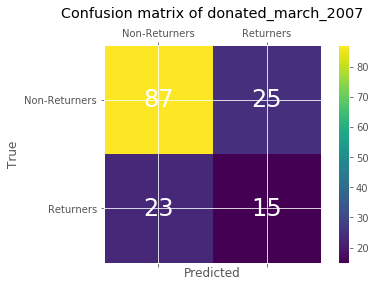

              precision    recall  f1-score   support

           0       0.79      0.78      0.78       112
           1       0.38      0.39      0.38        38

   micro avg       0.68      0.68      0.68       150
   macro avg       0.58      0.59      0.58       150
weighted avg       0.69      0.68      0.68       150



In [189]:
y_pred = rfc.predict(X_test)
con_mat(rfc, X_train, X_test, y_train, y_test, y_pred)

## Support Vector Machine Classification

Now let's take a look at a SVM model. SVM is particularly sensitive to the scale of the independent variables, so first we need to scale the data.

In [66]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.fit_transform(X_test)

Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
gamma = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = {'C':Cs, 
              'gamma':gamma}

svm = SVC(kernel='rbf')
svm_cv = GridSearchCV(svm, param_grid, cv=5, scoring='f1')
svm_cv.fit(X_train_s, y_train)

print("Tuned SVM Parameters: {}".format(svm_cv.best_params_)) 
print("Best score: {}".format(svm_cv.best_score_))

Tuned SVM Parameters: {'C': 1000, 'gamma': 1}
Best score: 0.7975756914610859


In [67]:
best_c = svm_cv.best_params_['C']
best_g = svm_cv.best_params_['gamma']

In [68]:
svm = SVC(kernel='rbf', C=best_c, gamma=best_g)
svm.fit(X_train_s, y_train)

print("Model accuracy:", accuracy_score(svm.predict(X_test_s), y_test))

Model accuracy: 0.6


[[84 28]
 [32  6]]


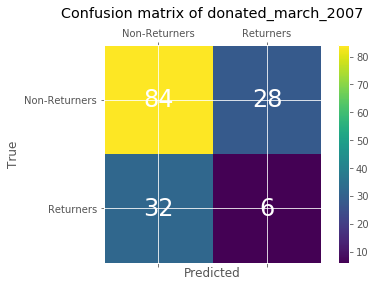

              precision    recall  f1-score   support

           0       0.72      0.75      0.74       112
           1       0.18      0.16      0.17        38

   micro avg       0.60      0.60      0.60       150
   macro avg       0.45      0.45      0.45       150
weighted avg       0.59      0.60      0.59       150



In [69]:
y_pred = svm.predict(X_test_s)
con_mat(svm, X_train_s, X_test_s, y_train, y_test, y_pred)

SVM didn't perform very well in comparison to the logistic regression model. However, we can check a linear SVM.

## Linear Support Vector Machines

In [74]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.fit_transform(X_test)

C_range = np.logspace(-2, 10, 13)
param_grid = {'C':C_range}

linsvm = LinearSVC(dual=False)
linsvm_cv = GridSearchCV(linsvm, param_grid, cv=5, scoring='recall')
linsvm_cv.fit(X_train_s, y_train)

print("Tuned SVM Parameters: {}".format(linsvm_cv.best_params_)) 
print("Best score: {}".format(linsvm_cv.best_score_))

Tuned SVM Parameters: {'C': 0.01}
Best score: 0.7969432314410481


In [75]:
best_c = linsvm_cv.best_params_['C']

In [76]:
linsvm = LinearSVC(C=best_c, dual=False)
linsvm.fit(X_train_s, y_train)

print("Model accuracy:", accuracy_score(linsvm.predict(X_test_s), y_test))

Model accuracy: 0.5666666666666667


[[55 57]
 [ 8 30]]


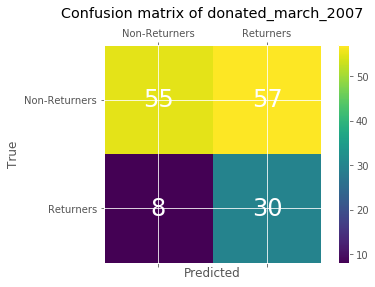

              precision    recall  f1-score   support

           0       0.87      0.49      0.63       112
           1       0.34      0.79      0.48        38

   micro avg       0.57      0.57      0.57       150
   macro avg       0.61      0.64      0.55       150
weighted avg       0.74      0.57      0.59       150



In [77]:
y_pred = linsvm.predict(X_test_s)
con_mat(linsvm, X_train_s, X_test_s, y_train, y_test, y_pred)

The goal is to minimize false negatives, so in that regard the linear SVM model performed very well, on par or perhaps slightly better than the logistic regression model.

## K-Nearest Neighbors Classifier

K-nearest neighbors takes the k neighbors of a point and has them perform a majority vote on what the point should be classified.

In [82]:
knn = KNeighborsClassifier()
n_neighbors = range(3, 31)
param_grid = {'n_neighbors':n_neighbors}
knn_cv = GridSearchCV(knn, param_grid, cv=5, scoring='recall')
knn_cv.fit(X_train, y_train)

print("Tuned KNN Parameters: {}".format(knn_cv.best_params_)) 
print("Best score: {}".format(knn_cv.best_score_))

Tuned KNN Parameters: {'n_neighbors': 3}
Best score: 0.834061135371179


/Users/josephpetersen/miniconda3/envs/springboard/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [83]:
best_n = knn_cv.best_params_['n_neighbors']

In [84]:
knn = KNeighborsClassifier(n_neighbors=best_n)
knn.fit(X_train, y_train)

print("Model accuracy:", accuracy_score(knn.predict(X_test), y_test))

Model accuracy: 0.6333333333333333


[[77 35]
 [20 18]]


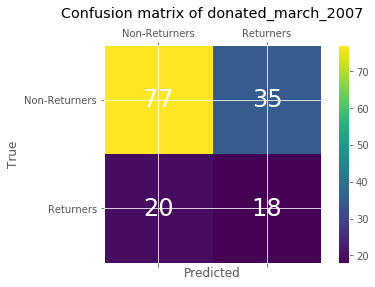

              precision    recall  f1-score   support

           0       0.79      0.69      0.74       112
           1       0.34      0.47      0.40        38

   micro avg       0.63      0.63      0.63       150
   macro avg       0.57      0.58      0.57       150
weighted avg       0.68      0.63      0.65       150



In [85]:
y_pred = knn.predict(X_test)
con_mat(knn, X_train, X_test, y_train, y_test, y_pred)

K-nearest neighbors did not perform better than either linear svm for logistic regression.

## Logistic Regression and LinearSVM on the Smaller Dataset

The frequency column is just a calculation of total_times_donated / months_since_first. It's possible the model could improve is we only used the frequency column and the one column not included in its calculation.

In [5]:
# The full dataset
df.head()

,months_since_first,months_since_last,total_times_donated,frequency,donated_march_2007
0,98,2,50,1.960000,1
1,28,0,13,2.153846,1
2,35,1,16,2.187500,1
3,45,2,20,2.250000,1
4,77,1,24,3.208333,0


In [6]:
# The dataset with just frequency and months_since_last
df_min.head()

,months_since_last,frequency,donated_march_2007
0,2,1.960000,1
1,0,2.153846,1
2,1,2.187500,1
3,2,2.250000,1
4,1,3.208333,0


In [7]:
# Splitting into training and testing sets and upsampling
X_train, X_test, y_train, y_test = train_test_split(df_min.drop('donated_march_2007', axis=1).values, 
                                             df_min.donated_march_2007.values, random_state=23, test_size=0.2)

In [8]:
Cs = [0.001, 0.01, 0.1, 1, 10, 100]
penalty =['l1', 'l2']
param_grid = {'C':Cs, 
              'penalty':penalty}
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, scoring='recall')
logreg_cv.fit(X_train, y_train)

print("Tuned LR Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score: {}".format(logreg_cv.best_score_))

Tuned LR Parameters: {'C': 0.1, 'penalty': 'l1'}
Best score: 0.7712613473483038


In [9]:
best_c = logreg_cv.best_params_['C']
best_p = logreg_cv.best_params_['penalty']

In [10]:
logreg = LogisticRegression(C=best_c, penalty=best_p, solver='liblinear', class_weight='balanced')
logreg.fit(X_train, y_train)
print("Model accuracy:", accuracy_score(logreg.predict(X_test), y_test))

Model accuracy: 0.6266666666666667


[[67 45]
 [11 27]]


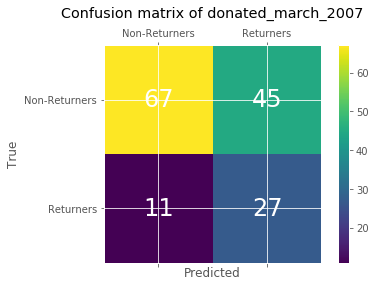

              precision    recall  f1-score   support

           0       0.86      0.60      0.71       112
           1       0.38      0.71      0.49        38

   micro avg       0.63      0.63      0.63       150
   macro avg       0.62      0.65      0.60       150
weighted avg       0.74      0.63      0.65       150



In [11]:
y_pred = logreg.predict(X_test)
con_mat(logreg, X_train, X_test, y_train, y_test, y_pred)

In [14]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.fit_transform(X_test)

C_range = np.logspace(-2, 10, 13)
param_grid = {'C':C_range}

linsvm = LinearSVC(dual=False, class_weight='balanced')
linsvm_cv = GridSearchCV(linsvm, param_grid, cv=5, scoring='recall')
linsvm_cv.fit(X_train_s, y_train)

print("Tuned SVM Parameters: {}".format(linsvm_cv.best_params_)) 
print("Best score: {}".format(linsvm_cv.best_score_))

Tuned SVM Parameters: {'C': 0.01}
Best score: 0.778368370759675


/Users/josephpetersen/miniconda3/envs/springboard/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [15]:
best_c = linsvm_cv.best_params_['C']

In [16]:
linsvm = LinearSVC(C=best_c, dual=False, class_weight='balanced')
linsvm.fit(X_train_s, y_train)

print("Model accuracy:", accuracy_score(linsvm.predict(X_test_s), y_test))

Model accuracy: 0.6066666666666667


[[62 50]
 [ 9 29]]


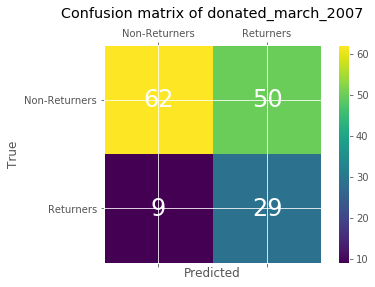

              precision    recall  f1-score   support

           0       0.87      0.55      0.68       112
           1       0.37      0.76      0.50        38

   micro avg       0.61      0.61      0.61       150
   macro avg       0.62      0.66      0.59       150
weighted avg       0.75      0.61      0.63       150



In [17]:
y_pred = linsvm.predict(X_test_s)
con_mat(linsvm, X_train_s, X_test_s, y_train, y_test, y_pred)

In [ ]:
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

print("Distribution of response variable (upscaled training set):")
print(pd.Series(y_train).value_counts())
print("Mean:", y_train.mean())

We're going to try the two models that were more effective on the full set, logistic regression and linear svm.

In [217]:
Cs = [0.001, 0.01, 0.1, 1, 10, 100]
penalty =['l1', 'l2']
param_grid = {'C':Cs, 
              'penalty':penalty}
logreg = LogisticRegression(solver='liblinear')
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, scoring='recall')
logreg_cv.fit(X_train, y_train)

print("Tuned LR Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score: {}".format(logreg_cv.best_score_))

Tuned LR Parameters: {'C': 1, 'penalty': 'l1'}
Best score: 0.7685589519650655


In [218]:
best_c = logreg_cv.best_params_['C']
best_p = logreg_cv.best_params_['penalty']

In [219]:
logreg = LogisticRegression(C=best_c, penalty=best_p, solver='liblinear')
logreg.fit(X_train, y_train)
print("Model accuracy:", accuracy_score(logreg.predict(X_test), y_test))

Model accuracy: 0.6266666666666667


[[66 46]
 [10 28]]


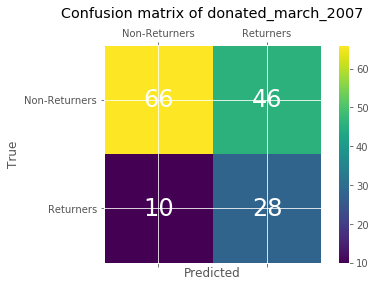

              precision    recall  f1-score   support

           0       0.87      0.59      0.70       112
           1       0.38      0.74      0.50        38

   micro avg       0.63      0.63      0.63       150
   macro avg       0.62      0.66      0.60       150
weighted avg       0.74      0.63      0.65       150



In [220]:
y_pred = logreg.predict(X_test)
con_mat(logreg, X_train, X_test, y_train, y_test, y_pred)

[[62 50]
 [ 7 31]]


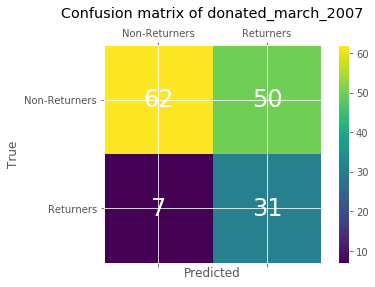

              precision    recall  f1-score   support

           0       0.90      0.55      0.69       112
           1       0.38      0.82      0.52        38

   micro avg       0.62      0.62      0.62       150
   macro avg       0.64      0.68      0.60       150
weighted avg       0.77      0.62      0.64       150



In [227]:
y_pred = logreg.predict_proba(X_test)
y_pred_adj = adjusted_threshold(y_pred, 0.45)
con_mat(logreg, X_train, X_test, y_train, y_test, y_pred_adj)

The logistic regression model performed about as well as it did on the full dataset.

In [210]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.fit_transform(X_test)

C_range = np.logspace(-2, 10, 13)
param_grid = {'C':C_range}

linsvm = LinearSVC(dual=False)
linsvm_cv = GridSearchCV(linsvm, param_grid, cv=5, scoring='recall')
linsvm_cv.fit(X_train_s, y_train)

print("Tuned SVM Parameters: {}".format(linsvm_cv.best_params_)) 
print("Best score: {}".format(linsvm_cv.best_score_))

Tuned SVM Parameters: {'C': 0.01}
Best score: 0.7729257641921398


In [211]:
best_c = linsvm_cv.best_params_['C']

In [212]:
linsvm = LinearSVC(C=best_c, dual=False)
linsvm.fit(X_train_s, y_train)

print("Model accuracy:", accuracy_score(linsvm.predict(X_test_s), y_test))

Model accuracy: 0.6


[[59 53]
 [ 7 31]]


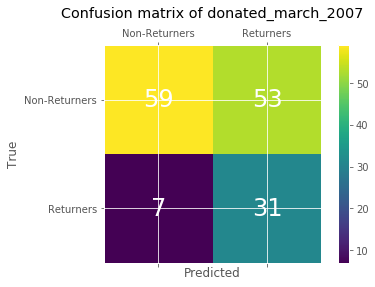

              precision    recall  f1-score   support

           0       0.89      0.53      0.66       112
           1       0.37      0.82      0.51        38

   micro avg       0.60      0.60      0.60       150
   macro avg       0.63      0.67      0.59       150
weighted avg       0.76      0.60      0.62       150



In [213]:
y_pred = linsvm.predict(X_test_s)
con_mat(linsvm, X_train_s, X_test_s, y_train, y_test, y_pred)

The linear svm model perfomed slightly better than it did on the full dataset.

In [214]:
train_acc = linsvm.score(X_train_s, y_train)
test_acc = linsvm.score(X_test_s, y_test)

print("Acc. on training data: %0.2f" % (train_acc))
print("Acc. on test data:     %0.2f" % (test_acc))

Acc. on training data: 0.69
Acc. on test data:     0.60


The two models that have been the most effective are the logistic regression model and the linear svm. The logistic regression model has fewer false positives but slightly more false negatives while the linear svm model has fewer false negatives but more false positives.

Let's try adjusting the threshold on this last model. 

In [215]:
cal = CalibratedClassifierCV(linsvm, cv=5)
cal.fit(X_train_s, y_train)

CalibratedClassifierCV(base_estimator=LinearSVC(C=0.01, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
            cv=5, method='sigmoid')

[[53 59]
 [ 7 31]]


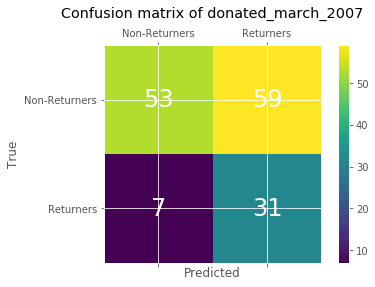

              precision    recall  f1-score   support

           0       0.88      0.47      0.62       112
           1       0.34      0.82      0.48        38

   micro avg       0.56      0.56      0.56       150
   macro avg       0.61      0.64      0.55       150
weighted avg       0.75      0.56      0.58       150



In [216]:
y_pred = cal.predict_proba(X_test_s)
y_pred_adj = adjusted_threshold(y_pred, 0.45)

con_mat(linsvm, X_train_s, X_test_s, y_train, y_test, y_pred_adj)

Adjusting the threshold has a higher effect on the number of false positives given the unbalanced response variable. Of the two models, it's a question of what HYPO would prefer. The initial goal was to minimize false negatives. In that regard, the linear svm model is the most effective.

## Dataset without Frequency

In [143]:
df_nf.head()

,months_since_first,months_since_last,total_times_donated,donated_march_2007
0,98,2,50,1
1,28,0,13,1
2,35,1,16,1
3,45,2,20,1
4,77,1,24,0


In [156]:
X_train, X_test, y_train, y_test = train_test_split(df_nf.drop('donated_march_2007', axis=1).values, 
                                             df_nf.donated_march_2007.values, random_state=23, test_size=0.2)

smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

print("Distribution of response variable (upscaled training set):")
print(pd.Series(y_train).value_counts())
print("Mean:", y_train.mean())

Distribution of response variable (upscaled training set):
1    458
0    458
dtype: int64
Mean: 0.5


In [157]:
Cs = [0.001, 0.01, 0.1, 1, 10, 100]
penalty =['l1', 'l2']
param_grid = {'C':Cs, 
              'penalty':penalty}
logreg = LogisticRegression(solver='liblinear')
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, scoring='recall')
logreg_cv.fit(X_train, y_train)

print("Tuned LR Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score: {}".format(logreg_cv.best_score_))

Tuned LR Parameters: {'C': 1, 'penalty': 'l2'}
Best score: 0.7641921397379913


In [158]:
best_c = logreg_cv.best_params_['C']
best_p = logreg_cv.best_params_['penalty']

In [159]:
logreg = LogisticRegression(C=best_c, penalty=best_p, solver='liblinear')
logreg.fit(X_train, y_train)
print("Model accuracy:", accuracy_score(logreg.predict(X_test), y_test))

Model accuracy: 0.6466666666666666


[[68 44]
 [ 9 29]]


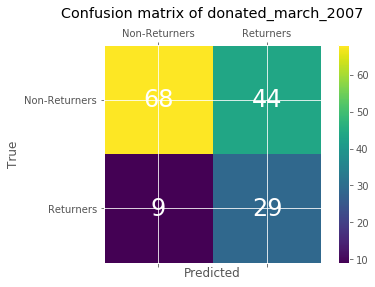

              precision    recall  f1-score   support

           0       0.88      0.61      0.72       112
           1       0.40      0.76      0.52        38

   micro avg       0.65      0.65      0.65       150
   macro avg       0.64      0.69      0.62       150
weighted avg       0.76      0.65      0.67       150



In [160]:
y_pred = logreg.predict(X_test)
con_mat(logreg, X_train, X_test, y_train, y_test, y_pred)

In [161]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.fit_transform(X_test)

C_range = np.logspace(-2, 10, 13)
param_grid = {'C':C_range}

linsvm = LinearSVC(dual=False)
linsvm_cv = GridSearchCV(linsvm, param_grid, cv=5, scoring='recall')
linsvm_cv.fit(X_train_s, y_train)

print("Tuned SVM Parameters: {}".format(linsvm_cv.best_params_)) 
print("Best score: {}".format(linsvm_cv.best_score_))

Tuned SVM Parameters: {'C': 0.01}
Best score: 0.7729257641921398


/Users/josephpetersen/miniconda3/envs/springboard/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/josephpetersen/miniconda3/envs/springboard/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/josephpetersen/miniconda3/envs/springboard/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/josephpetersen/miniconda3/envs/springboard/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [162]:
best_c = linsvm_cv.best_params_['C']

In [163]:
linsvm = LinearSVC(C=best_c, dual=False)
linsvm.fit(X_train_s, y_train)

print("Model accuracy:", accuracy_score(linsvm.predict(X_test_s), y_test))

Model accuracy: 0.56


[[55 57]
 [ 9 29]]


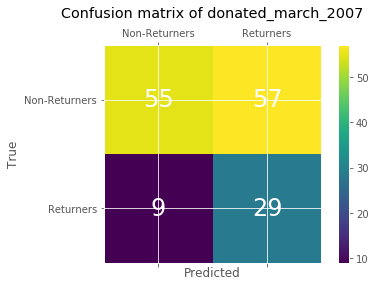

              precision    recall  f1-score   support

           0       0.86      0.49      0.62       112
           1       0.34      0.76      0.47        38

   micro avg       0.56      0.56      0.56       150
   macro avg       0.60      0.63      0.55       150
weighted avg       0.73      0.56      0.59       150



In [164]:
y_pred = linsvm.predict(X_test_s)
con_mat(linsvm, X_train_s, X_test_s, y_train, y_test, y_pred)